In [1]:
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.9 MB/s eta 0:00:00


In [2]:
ls /kaggle/input/vae_catdog/pytorch/default/3

ls: cannot access '/kaggle/input/vae_catdog/pytorch/default/3': No such file or directory


In [3]:
import os
import glob
from PIL import Image
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms
from tqdm import tqdm
import numpy as np
import math
from torchvision.utils import make_grid
from einops import rearrange
import functools
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt

def get_device():
    return torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

device = get_device()

class catDogDataset(Dataset):
    def __init__(self, cat_directories, dog_directories, common_directories,
                 file_extensions=["*.jpg", "*.png", "*.jpeg"],
                 transform=None):
        self.files_and_labels = []
        self.cat_samples = 0 
        self.dog_samples = 0
        for ext in file_extensions:
            for directory in cat_directories:
                cat_files = glob.glob(os.path.join(directory, "**", ext), recursive=True)
                print(f"{len(cat_files)} {ext} cat images in {directory}")
                self.cat_samples += len(cat_files)
                cat_files = [[file, 0] for file in cat_files]
                self.files_and_labels.extend(cat_files)
            for directory in dog_directories:
                dog_files = glob.glob(os.path.join(directory, "**", ext), recursive=True)
                self.dog_samples += len(dog_files)
                print(f"{len(dog_files)} {ext} dog images in {directory}")
                dog_files = [[file, 1] for file in dog_files]
                self.files_and_labels.extend(dog_files)
            for directory in common_directories:
                dog_files = glob.glob(os.path.join(directory, "**", f"dog{ext}"), recursive=True)
                self.dog_samples += len(dog_files)
                print(f"{len(dog_files)} {ext} dog images in {directory}")
                dog_files = [[file, 1] for file in dog_files]
                self.files_and_labels.extend(dog_files)
                cat_files = glob.glob(os.path.join(directory, "**", f"cat{ext}"), recursive=True)
                self.cat_samples += len(cat_files)
                print(f"{len(cat_files)} {ext} cat images in {directory}")
                cat_files = [[file, 0] for file in cat_files]
                self.files_and_labels.extend(cat_files)
        self.transform = transform
    
    def __len__(self):
        return len(self.files_and_labels)

    def __getitem__(self, idx):
        file_path, label = self.files_and_labels[idx]
        try:
            image = Image.open(file_path)

            if image.mode == 'L':  # Check if the image is grayscale
                new_idx = (idx + 1) % len(self)
                return self.__getitem__(new_idx)

            image = image.convert('RGB')

            if self.transform:
                image = self.transform(image)
            return image, label
        
        except Exception as e:
            new_idx = (idx + 1) % len(self)
            return self.__getitem__(new_idx)
        

cat_directories = [
    '/kaggle/input/afhq-512/cat',
]

dog_directories = [
    '/kaggle/input/afhq-512/dog',
]

common_directories = [
#     "/kaggle/input/cat-dog-64x64-pixel/CatDog"
                     ]

img_shape = (3, 256, 256)

augmentation = transforms.Compose([
    transforms.Resize(img_shape[1:]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15), # seems like it also learns the rotation feature so minimize it
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.07),
    transforms.RandomPerspective(p=0.35, distortion_scale=0.15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# dataset = catDogDataset(cat_directories, dog_directories, common_directories, transform=augmentation)
# print("Dataset size: ",len(dataset))
# print("Dog images: ", dataset.dog_samples)
# print("Cat images: ", dataset.cat_samples)

In [4]:
NEG_INFTY = -1e9

def scaled_dot_product(q, k, v):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

# provide some unique embedding data for each step
class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
        
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class Dense(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)
        self.act = nn.SiLU()
        self.dense2 = nn.Linear(output_dim, output_dim)
        
    def forward(self, x):
        x = self.dense(x)
        x = self.act(x)
        x = self.dense2(x)
        x = self.act(x)
        return x[..., None, None]

def marginal_prob_std(t, sigma):
    """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

    Args:    
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.  

    Returns:
    The standard deviation.
    """    
    t = torch.tensor(t, device=device)
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
    """Compute the diffusion coefficient of our SDE.

    Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

    Returns:
    The vector of diffusion coefficients.
    """
    return torch.tensor(sigma**t, device=device)
  
sigma =  25.0#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

class ConditionEmbed(nn.Module):
    def __init__(self, label_size, embed_dim):
        super(ConditionEmbed, self).__init__()
        self.embed = nn.Embedding(label_size+1, embed_dim)

    def forward(self, ids):
        return self.embed(ids)
    
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(d_model, 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def forward(self, x):
        batch_size, sequence_length, d_model = x.size()
        qkv = self.qkv_layer(x)
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3)
        q, k, v = qkv.chunk(3, dim=-1)
        values, attention = scaled_dot_product(q, k, v)
        values = values.permute(0, 2, 1, 3).reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        out = self.linear_layer(values)
        return out
    
class MultiHeadCrossAttention(nn.Module):
    def __init__(self, d_model, num_heads, context_dim):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.kv_layer = nn.Linear(context_dim, 2 * d_model)
        self.q_layer = nn.Linear(d_model, d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def forward(self, x, y):
        # x is context (closer to encoder side) to attend to
        # y is the image value before cross attention
        batch_size, x_length, _ = x.size()
        _, y_length, d_model = y.size()
        kv = self.kv_layer(x)
        q = self.q_layer(y)
        kv = kv.reshape(batch_size, x_length, self.num_heads, 2 * self.head_dim)
        q = q.reshape(batch_size, y_length, self.num_heads, self.head_dim)
        kv = kv.permute(0, 2, 1, 3)
        q = q.permute(0, 2, 1, 3)
        k, v = kv.chunk(2, dim=-1)
        values, attention = scaled_dot_product(q, k, v)
        values = values.permute(0,2,1,3).reshape(batch_size, y_length, d_model)
        out = self.linear_layer(values)
        return out

class SpatialTransformer(nn.Module):
    def __init__(self, hidden_dim, context_dim=256, num_heads=4):
        super().__init__()
        self.self_attention = MultiHeadSelfAttention(hidden_dim, num_heads)
        self.cross_attention = MultiHeadCrossAttention(hidden_dim, num_heads, context_dim)
        self.ffn = nn.Sequential(nn.Linear(hidden_dim, hidden_dim*4, bias=False),
                                 nn.Linear(hidden_dim*4, hidden_dim, bias=False),
                                 nn.GELU())
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.norm3 = nn.LayerNorm(hidden_dim)
    
    def forward(self, y, x):
        b, c, h, w = y.shape
        y = rearrange(y, "b c h w->b (h w) c")
        res_y = y.clone()
        y = self.self_attention(y)
        y = self.norm1(y + res_y)
        
        res_y = y.clone()
        y = self.cross_attention(x, y)
        y = self.norm1(y + res_y)
        
        res_y = y.clone()
        y = self.ffn(y)
        y = self.norm3(y + res_y)
        y = rearrange(y, 'b (h w) c -> b c h w', h=h, w=w)
        return y
    
class ResBlock(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.layers = nn.Sequential(nn.Conv2d(channels_in, channels_out, 3, 
                                              stride=1, padding='same', padding_mode='reflect', 
                                              bias=False),
                                    nn.GroupNorm(4, num_channels=channels_out),
                                    nn.GELU(),
                                    nn.Conv2d(channels_out, channels_out, 3, 
                                              stride=1, padding='same', padding_mode='reflect', 
                                              bias=False),
                                    nn.GroupNorm(4, num_channels=channels_out))
    def forward(self, x):
        return nn.GELU()(self.layers(x) + x)
    
class DoubleConv(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.layers = nn.Sequential(nn.Conv2d(channels_in, channels_out, 3, 
                                              stride=1, padding='same', padding_mode='reflect', 
                                              bias=False),
                                    nn.GroupNorm(4, num_channels=channels_out),
                                    nn.GELU(),
                                    nn.Conv2d(channels_out, channels_out, 3, 
                                              stride=1, padding='same', padding_mode='reflect', 
                                              bias=False),
                                    nn.GroupNorm(4, num_channels=channels_out),
                                    nn.GELU())
    def forward(self, x):
        return self.layers(x)

In [5]:
class AutoEncoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(nn.Conv2d(in_channels = 3,out_channels = 32, kernel_size = 3, padding = 'same', padding_mode='reflect'),
                                     nn.GroupNorm(4, num_channels=32),
                                     nn.SiLU(),
                                     ResBlock(32, 32),
                                     # 32 x 256 x 256
                                     nn.Conv2d(in_channels = 32,out_channels = 64, stride = 2, kernel_size = 3, padding = 1, padding_mode='reflect'),
                                     nn.GroupNorm(4, num_channels=64),
                                     nn.SiLU(),
                                     ResBlock(64, 64),
                                     # 64 x 128 x 128
                                     nn.Conv2d(in_channels = 64, out_channels = 128, stride = 2, kernel_size = 3, padding = 1, padding_mode='reflect'),
                                     nn.GroupNorm(4, num_channels=128),
                                     nn.SiLU(),
                                     ResBlock(128, 128),
                                     # 128 x 64 x 64
                                     nn.Conv2d(in_channels = 128, out_channels = 256, stride = 2, kernel_size = 3, padding = 1, padding_mode='reflect'),
                                     nn.GroupNorm(4, num_channels=256),
                                     nn.SiLU(),
                                     ResBlock(256, 256),
                                     # 256 x 32 x 32
                                     nn.Conv2d(in_channels = 256, out_channels = latent_dim, kernel_size = 3, padding = 'same', padding_mode='reflect')
                                    )
        
        self.decoder = nn.Sequential(nn.Conv2d(latent_dim, 256, kernel_size = 3, padding = 'same', padding_mode='reflect'),
                                     ResBlock(256, 256),
                                     # 256 x 32 x 32
                                     nn.Upsample(scale_factor = 2),
                                     nn.Conv2d(in_channels = 256, out_channels = 128, stride = 1, kernel_size = 3, padding = 'same', padding_mode='reflect'),
                                     nn.GroupNorm(4, num_channels=128),
                                     nn.SiLU(),
                                     ResBlock(128, 128),
                                     # 128 x 64 x 64
                                     nn.Upsample(scale_factor = 2),
                                     nn.Conv2d(in_channels = 128, out_channels = 64, stride = 1, kernel_size = 3, padding = 'same', padding_mode='reflect'),
                                     nn.GroupNorm(4, num_channels=64),
                                     nn.SiLU(),
                                     ResBlock(64, 64),
                                     # 64 x 128 x 128
                                     nn.Upsample(scale_factor = 2),
                                     nn.Conv2d(in_channels = 64, out_channels = 32, stride = 1, kernel_size = 3, padding = 'same', padding_mode='reflect'),
                                     nn.GroupNorm(4, num_channels=32),
                                     nn.SiLU(),
                                     ResBlock(32, 32),
                                     # 256 x 32 x 32
                                     nn.Conv2d(in_channels = 32, out_channels = 3, kernel_size = 3, padding = 'same', padding_mode='reflect')
                                    )
    
    def forward(self, x):
        encoded = self.encoder(x)
        return self.decoder(encoded)

In [6]:
def get_device():
    return torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

device = get_device()

In [7]:
batch_size = 16
# data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
latent_dim = 8
vae = AutoEncoder(latent_dim=latent_dim).to(device)

In [8]:
pip install lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [9]:
from lpips import LPIPS

lpips = LPIPS(net="squeeze").cuda() if torch.cuda.is_available() else LPIPS(net="squeeze")
loss_fn_ae = lambda x,xhat: nn.functional.mse_loss(x, xhat) + lpips(x, xhat).mean()

def latent_loss_function(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

def train_vae(model, train_loader, optimizer, scheduler, epochs):
    model.train()
    for epoch in range(epochs):
        train_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch = model(data)
            loss = loss_fn_ae(recon_batch, data)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        scheduler.step()
        print(f'Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset)}')
        
ckpt = torch.load('/kaggle/input/variantencoder/ckpt_vae.pth',map_location=device)
vae.load_state_dict(ckpt, strict=False) # architecture changes several time

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth


Setting up [LPIPS] perceptual loss: trunk [squeeze], v[0.1], spatial [off]


100%|██████████| 4.73M/4.73M [00:00<00:00, 70.2MB/s]

Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/squeeze.pth


<All keys matched successfully>

**THIS CODE TRAIN VARIANT ENCODER**

In [10]:
# optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4)
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.3, 0.97 ** epoch))

# train_vae(vae, data_loader, optimizer, scheduler, epochs=12)
# torch.save(vae.state_dict(), 'ckpt_vae.pth')

In [11]:
mean=torch.tensor([0.485, 0.456, 0.406])
std=torch.tensor([0.229, 0.224, 0.225])
def bgr_to_rgb(bgr_tensor):
    # Rearrange the channel order: [B, G, R] to [R, G, B]
    rgb_tensor = bgr_tensor[:, [2, 1, 0], :, :]  # Swap B and R channels
    return rgb_tensor

def reverse_standardization(standardized_tensor, mean=mean, std=std):
    # Ensure mean and std are broadcastable
    mean = mean.view(1, -1, 1, 1)
    std = std.view(1, -1, 1, 1)
    
    # Apply the inverse standardization
    original_tensor = standardized_tensor * std + mean
    return original_tensor

In [12]:
# vae.eval()
# x, y = next(iter(data_loader))
# x_hat = vae(x.to(device)).cpu()

# x_rev = torch.clone(torch.tensor(x))
# x_rev = reverse_standardization(x_rev)
# x_rev = x_rev.clamp(0.0, 1.0)

# x_hat_rev = torch.clone(x_hat)
# x_hat_rev = reverse_standardization(x_hat_rev)
# x_hat_rev = x_hat_rev.clamp(0.0, 1.0)

In [13]:
# plt.figure(figsize=(6,6.5))
# plt.axis('off')
# plt.imshow(make_grid(x_rev[:64,:,:,:]).permute([1,2,0]), vmin=0., vmax=1.)
# plt.title("Original")
# plt.show()

# plt.figure(figsize=(6,6.5))
# plt.axis('off')
# plt.imshow(make_grid(x_hat_rev[:64,:,:,:]).permute([1,2,0]), vmin=0., vmax=1.)
# plt.title("AE Reconstructed")
# plt.show()

In [14]:
class UnetDiffusion(nn.Module):
    def __init__(self, marginal_prob_std, 
                 input_channel=latent_dim,
                 channels=[128, 256, 512, 1024], 
                 embed_dim=256, 
                 text_dim=256, 
                 nClass=2):
        super().__init__()
        
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim)
            )
        # extract information
        self.conv_act = nn.SiLU()
        self.conv = nn.Conv2d(input_channel, channels[0], 3, padding=1, padding_mode='reflect', bias=False)
        self.norm = nn.GroupNorm(4, num_channels=channels[0])
        self.conv1 = ResBlock(channels[0], channels[0])
        self.dense1 = Dense(embed_dim, channels[0]) 
        self.conv2 = ResBlock(channels[0], channels[0])
        self.dense2 = Dense(embed_dim, channels[0]) 
        
        self.down1 = nn.Conv2d(channels[0], channels[1], 3, stride=2, padding=1, padding_mode='reflect', bias=False)
        self.norm1 = nn.GroupNorm(4, num_channels=channels[1])
        self.resblock1_1 = ResBlock(channels[1], channels[1])
        self.dense1_1 = Dense(embed_dim, channels[1]) 
        self.block1_1 = SpatialTransformer(channels[1], text_dim)
        self.resblock1_2 = ResBlock(channels[1], channels[1])
        self.dense1_2 = Dense(embed_dim, channels[1])
        self.resblock1_3 = ResBlock(channels[1], channels[1])
        self.dense1_3 = Dense(embed_dim, channels[1]) # 256 x 16 x 16
        
        self.down2 = nn.Conv2d(channels[1], channels[2], 3, stride=2, padding=1, padding_mode='reflect', bias=False)
        self.norm2 = nn.GroupNorm(4, num_channels=channels[2])
        self.resblock2_1 = ResBlock(channels[2], channels[2])
        self.dense2_1 = Dense(embed_dim, channels[2]) 
        self.block2_1 = SpatialTransformer(channels[2], text_dim)
        self.resblock2_2 = ResBlock(channels[2], channels[2])
        self.dense2_2 = Dense(embed_dim, channels[2])
        self.resblock2_3 = ResBlock(channels[2], channels[2])
        self.dense2_3 = Dense(embed_dim, channels[2]) # 512 x 8 x 8
        
        self.down3 = nn.Conv2d(channels[2], channels[3], 3, stride=2, padding=1, padding_mode='reflect', bias=False)
        self.norm3 = nn.GroupNorm(4, num_channels=channels[3])
        self.resblock3_1 = ResBlock(channels[3], channels[3])
        self.dense3_1 = Dense(embed_dim, channels[3]) 
        self.block3_1 = SpatialTransformer(channels[3], text_dim)
        self.resblock3_2 = ResBlock(channels[3], channels[3])
        self.dense3_2 = Dense(embed_dim, channels[3])
        self.resblock3_3 = ResBlock(channels[3], channels[3])
        self.dense3_3 = Dense(embed_dim, channels[3]) # 1024 x 4 x 4
        
        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, padding=1, output_padding=1, bias=False) 
        self.norm4 = nn.GroupNorm(4, num_channels=channels[2])
        self.block4_1 = SpatialTransformer(channels[3], text_dim)
        self.conv4 = DoubleConv(channels[3], channels[2])
        self.resblock4_1 = ResBlock(channels[2], channels[2])
        self.dense4_1 = Dense(embed_dim, channels[2])
        self.resblock4_2 = ResBlock(channels[2], channels[2])
        self.dense4_2 = Dense(embed_dim, channels[2])
        self.resblock4_3 = ResBlock(channels[2], channels[2])
        self.dense4_3 = Dense(embed_dim, channels[2]) # 512 x 8 X 8

        self.tconv5 = nn.ConvTranspose2d(channels[2], channels[1], 3, stride=2, padding=1, output_padding=1, bias=False) 
        self.norm5 = nn.GroupNorm(4, num_channels=channels[1])
        self.block5_1 = SpatialTransformer(channels[2], text_dim)
        self.conv5 = DoubleConv(channels[2], channels[1])
        self.resblock5_1 = ResBlock(channels[1], channels[1])
        self.dense5_1 = Dense(embed_dim, channels[1])
        self.resblock5_2 = ResBlock(channels[1], channels[1])
        self.dense5_2 = Dense(embed_dim, channels[1])
        self.resblock5_3 = ResBlock(channels[1], channels[1])
        self.dense5_3 = Dense(embed_dim, channels[1]) # 256 x 16 X 16
        
        self.tconv6 = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=2, padding=1, output_padding=1, bias=False) 
        self.norm6 = nn.GroupNorm(4, num_channels=channels[0])
        self.block6_1 = SpatialTransformer(channels[1], text_dim)
        self.conv6 = DoubleConv(channels[1], channels[0])
        self.resblock6_1 = ResBlock(channels[0], channels[0])
        self.dense6_1 = Dense(embed_dim, channels[0])
        self.resblock6_2 = ResBlock(channels[0], channels[0])
        self.dense6_2 = Dense(embed_dim, channels[0])
        self.resblock6_3 = ResBlock(channels[0], channels[0])
        self.dense6_3 = Dense(embed_dim, channels[0]) # 128 x 32 X 32
        self.norm6_2 = nn.GroupNorm(4, num_channels=channels[0])
        
        self.res_final = ResBlock(channels[0], channels[0])
        self.conv_final = nn.Conv2d(channels[0], input_channel, 3, padding=1, stride=1, bias=False)
        # The swish activation function
        self.act = nn.SiLU() # lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std
        self.cond_embed = ConditionEmbed(label_size=nClass, embed_dim=text_dim)
    
    def forward(self, x, t, y):
        # x is the input image
        # t is time step
        # y is the context text
        t_embed = self.act(self.time_embed(t))
        y_embed = self.cond_embed(y).unsqueeze(1) # 256
        
        # Encoding path
        
        # To get things started, convolution to get the number of channels to some what 32
        # Not an encoder but could be one for latent diffusion
        h1 = self.conv(x)
        h1 = self.act(self.norm(h1))
        h1 = self.conv1(h1) + self.dense1(t_embed)
        h1 = self.conv2(h1) + self.dense2(t_embed)
        
        h2 = self.down1(h1) # 256 x 16 x 16
        h2 = self.act(self.norm1(h2))
        h2 = self.resblock1_1(h2) + self.dense1_1(t_embed)
        h2 = self.block1_1(h2, y_embed) # attention block
        h2 = self.resblock1_2(h2) + self.dense1_2(t_embed)
        h2 = self.resblock1_3(h2) + self.dense1_3(t_embed)
        h2 = self.act(h2)
        
        h3 = self.down2(h2) # 512 x 8 x 8
        h3 = self.act(self.norm2(h3))
        h3 = self.resblock2_1(h3) + self.dense2_1(t_embed)
        h3 = self.block2_1(h3, y_embed) # attention block
        h3 = self.resblock2_2(h3) + self.dense2_2(t_embed)
        h3 = self.resblock2_3(h3) + self.dense2_3(t_embed)
        h3 = self.act(h3)
        
        h4 = self.down3(h3) # 1024 x 4 x 4
        h4 = self.act(self.norm3(h4))
        h4 = self.resblock3_1(h4) + self.dense3_1(t_embed)
        h4 = self.block3_1(h4, y_embed) # attention block
        h4 = self.resblock3_2(h4) + self.dense3_2(t_embed)
        h4 = self.resblock3_3(h4) + self.dense3_3(t_embed)
        h4 = self.act(h4)
        
        h = self.tconv4(h4) # 512 x 8 x 8
        h = self.act(self.norm4(h))
        h = torch.cat((h, h3), dim=1) # 1024 x 8 x 8
        h = self.block4_1(h, y_embed)
        h = self.conv4(h) # 512 x 8 x 8
        h = self.resblock4_1(h) + self.dense4_1(t_embed) 
        h = self.resblock4_2(h) + self.dense4_2(t_embed)
        h = self.resblock4_3(h) + self.dense4_3(t_embed)
        h = self.act(h)
        
        h = self.tconv5(h) # 256 x 16 x 16
        h = self.act(self.norm5(h))
        h = torch.cat((h, h2), dim=1) # 512 x 16 x 16
        h = self.block5_1(h, y_embed)
        h = self.conv5(h) # 256 x 16 x 16
        h = self.resblock5_1(h) + self.dense5_1(t_embed)
        h = self.resblock5_2(h) + self.dense5_2(t_embed)
        h = self.resblock5_3(h) + self.dense5_3(t_embed)
        h = self.act(h)
        
        h = self.tconv6(h) # 128 x 32 x 32
        h = self.act(self.norm6(h))
        h = torch.cat((h, h1), dim=1) # 256 x 32 x 32
        h = self.block6_1(h, y_embed)
        h = self.conv6(h) # 128 x 32 x 32
        h = self.resblock6_1(h) + self.dense6_1(t_embed)
        h = self.resblock6_2(h) + self.dense6_2(t_embed)
        h = self.resblock6_3(h) + self.dense6_3(t_embed)
        h = self.act(h)
        
        h = self.res_final(h)
        h = self.conv_final(h)
        
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h

In [15]:
num_steps = 300
eps = 1e-3
time_set = torch.linspace(1., eps, num_steps, device=device)
p_t = torch.ones(num_steps, device=device)
step_size = time_set[0] - time_set[1]

def loss_fn_cond(model, x, y, marginal_prob_std, eps=1e-5, time_set=time_set):
    """The loss function for training score-based generative models.

    Args:
        model: A PyTorch model instance that represents a 
          time-dependent score-based model.
        x: A mini-batch of training data.    
        marginal_prob_std: A function that gives the standard deviation of 
          the perturbation kernel.
        eps: A tolerance value for numerical stability.
    """
#     t_indexes = p_t.multinomial(num_samples=x.shape[0], replacement=True)
#     random_t = time_set[t_indexes]
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  
    z = torch.randn_like(x)
    std = marginal_prob_std(random_t)
    perturbed_x = x + z * std[:, None, None, None]
    score = model(perturbed_x, random_t, y=y)
    # finding the noise that need to subtract from the output
    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
    return loss

In [16]:
label_map = {'cat': 0, 'dog': 1}

score_model = torch.nn.DataParallel(UnetDiffusion(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

In [17]:
def gen_new_latent_dataset(vae, orig_data_loader):
    vae.requires_grad_(False)
    vae.eval()
    zs = []
    ys = []
    for x, y in orig_data_loader:
        z = vae.encoder(x.to(device)).cpu()
        y = y.cpu()
        zs.append(z)
        ys.append(y)
    zdata = torch.cat(zs, )
    ydata = torch.cat(ys, )
    return TensorDataset(zdata, ydata)

In [18]:
ckpt = torch.load('/kaggle/input/latent-diffusion/latent_diffusion.pth',map_location=device)
score_model.load_state_dict(ckpt, strict=False)

<All keys matched successfully>

**THIS CODE TRAIN STABLE DIFFUSION**

In [19]:
# n_epochs = 70
# batch_size = 32
# lr = 1e-4

# optimizer = torch.optim.Adam(score_model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.3, 0.98 ** epoch))
# tqdm_epoch = trange(n_epochs)
# regenerate_latent = 2
# score_model.train()

# for epoch in tqdm_epoch:
#     avg_loss = 0.
#     num_items = 0
#     if epoch % regenerate_latent == 0:
#         print("Regenerate data ... ")
#         latent_dataset = gen_new_latent_dataset(vae, orig_data_loader=data_loader) # to augment data
#         latent_data_loader = DataLoader(latent_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
#         torch.cuda.empty_cache()
#     for x, y in tqdm(latent_data_loader):
#         x = x.to(device)
#         y = y.to(device)
#         loss = loss_fn_cond(score_model, x, y, marginal_prob_std_fn)
#         optimizer.zero_grad()
#         loss.backward()    
#         optimizer.step()
#         avg_loss += loss.item() * x.shape[0]
#         num_items += x.shape[0]
#     scheduler.step()
#     lr_current = scheduler.get_last_lr()[0]
#     avg_loss = avg_loss / num_items
#     print('{} Average Loss: {:5f} lr {:.1e}'.format(epoch, avg_loss, lr_current))
#     # Print the averaged training loss so far.
#     tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
#     # Update the checkpoint after each epoch of training.
#     torch.save(score_model.state_dict(), 'latent_diffusion.pth')

In [20]:
# param_size = 0
# for param in score_model.parameters():
#     param_size += param.nelement() * param.element_size()
# buffer_size = 0
# for buffer in score_model.buffers():
#     buffer_size += buffer.nelement() * buffer.element_size()

# size_all_mb = (param_size + buffer_size) / 1024**2
# print('model size: {:.3f}MB'.format(size_all_mb))

In [21]:
def Euler_Maruyama_sampler(score_model, 
              marginal_prob_std,
              diffusion_coeff, 
              batch_size=64, 
              x_shape=(latent_dim, 32, 32),
              num_steps=num_steps, 
              device='cuda', 
              eps=1e-3, y=None):
    """Generate samples from score-based models with the Euler-Maruyama solver.

    Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

    Returns:
    Samples.    
    """
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, *x_shape, device=device) \
    * marginal_prob_std(t)[:, None, None, None]
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    with torch.no_grad():
        for time_step in tqdm(time_steps):      
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diffusion_coeff(batch_time_step)
            mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step, y=y) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)      
            # Do not include any noise in the last sampling step.
    return mean_x

In [22]:
decoder = vae.decoder

/tmp/ipykernel_34/2706218321.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_34/2706218321.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


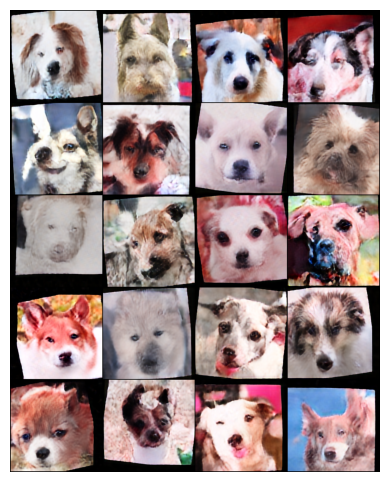

In [25]:
prompt = 'dog' 
label = label_map[prompt]
sample_batch_size = 20
num_steps = 200 
sampler = Euler_Maruyama_sampler 

samples = sampler(score_model, 
        marginal_prob_std_fn,
        diffusion_coeff_fn, 
        sample_batch_size,
        num_steps=num_steps,
        device=device,
        y=(label*torch.ones(sample_batch_size, dtype=torch.long)).to(device))

decoded = decoder(samples).cpu()
decoded_rev = reverse_standardization(decoded)
decoded_rev = decoded_rev.clamp(0.0, 1.0)

%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(decoded_rev, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

/tmp/ipykernel_34/2706218321.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_34/2706218321.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


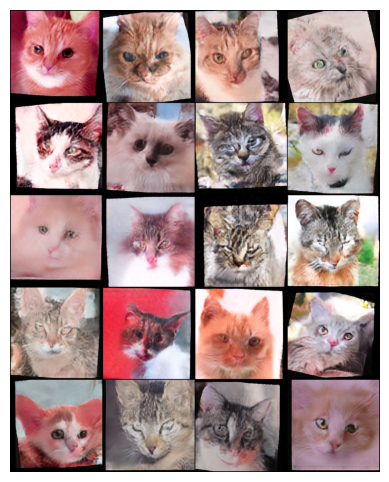

In [26]:
prompt = 'cat' 
label = label_map[prompt]
sample_batch_size = 20
num_steps = 200 
sampler = Euler_Maruyama_sampler 

samples = sampler(score_model, 
        marginal_prob_std_fn,
        diffusion_coeff_fn, 
        sample_batch_size,
        num_steps=num_steps,
        device=device,
        y=(label*torch.ones(sample_batch_size, dtype=torch.long)).to(device))

decoded = decoder(samples).cpu()
decoded_rev = reverse_standardization(decoded)
decoded_rev = decoded_rev.clamp(0.0, 1.0)

%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(decoded_rev, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()